In [1]:
from PIL import Image
import sys
import os
import urllib
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from tf_trt_models.classification import download_classification_checkpoint, build_classification_graph

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
from keras import backend as K

def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def fbeta(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

Using TensorFlow backend.


In [50]:
# Load model without TensorRT improvement
from keras.models import load_model
filepath = 'w251/model_params/binary_equal_trainentiremodel_50kimage_300epoch_model_weights.h5' 

model = load_model(filepath, custom_objects={'precision': precision, 'recall':recall, 'f1':f1, 'fbeta':fbeta,
                                            'precision_m': precision_m, 'recall_m':recall_m})


In [6]:
model.layers[0].input_shape

(None, 300, 300, 3)

In [47]:
from keras.preprocessing.image import load_img
import numpy as np
img = load_img('w251/roasted-asparagus-horiz-a-1600.jpg', target_size = (300,300))
img = np.expand_dims(img, axis = 0)
pred = np.argmax(model.predict(img), axis=1)[0]
pred

1

In [51]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
TEST_DIR = 'w251/Validation/Binary_Validation'
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                 target_size = (300,300),
                                                 batch_size = 16,
                                                 shuffle = False)

pred= model.predict_generator(test_generator, 695/16)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels[str(k)] for k in predicted_class_indices]

Found 695 images belonging to 2 classes.


[[289   0]
 [  4 402]]


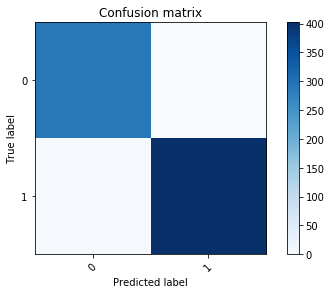

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.classes, predicted_class_indices)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels.keys()))
    plt.xticks(tick_marks, labels.keys(), rotation=45)
    plt.yticks(tick_marks, labels.keys())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(cm)
plot_confusion_matrix(cm)

from keras.models import load_model
filepath = 'w251/model_params/binary_equal_tanh_model_weights.h5'
model = load_model(filepath, custom_objects={'precision': precision, 'recall':recall, 'f1':f1, 'fbeta':fbeta,
                                            'precision_m': precision_m, 'recall_m':recall_m})
model.summary()

In [5]:
import tensorflow as tf
from tensorflow.python.framework import graph_io
from keras.models import load_model
filepath = 'w251/model_params/binary_default_model_weights.h5' 
save_pb_dir = 'w251'
def freeze_graph(graph, session, output, save_pb_dir='.', save_pb_name='frozen_model.pb', save_pb_as_text=False):
    with graph.as_default():
        graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())
        graphdef_frozen = tf.graph_util.convert_variables_to_constants(session, graphdef_inf, output)
        graph_io.write_graph(graphdef_frozen, save_pb_dir, save_pb_name, as_text=save_pb_as_text)
        return graphdef_frozen
# This line must be executed before loading Keras model.
tf.keras.backend.set_learning_phase(0) 

model = load_model(filepath, custom_objects={'precision': precision, 'recall':recall, 'f1':f1, 'fbeta':fbeta,
                                            'precision_m': precision_m, 'recall_m':recall_m})

session = tf.keras.backend.get_session()

input_names = [t.op.name for t in model.inputs]
output_names = [t.op.name for t in model.outputs]

# Prints input and output nodes names, take notes of them.
print(input_names, output_names)

frozen_graph = freeze_graph(session.graph, session, [out.op.name for out in model.outputs], save_pb_dir=save_pb_dir)


['input_2'] ['dense_15/Softmax']


FailedPreconditionError: 2 root error(s) found.
  (0) Failed precondition: Attempting to use uninitialized value bn4e_branch2c_1/gamma
	 [[node bn4e_branch2c_1/gamma (defined at /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422) ]]
	 [[bn3a_branch1_1/moving_mean/_741]]
  (1) Failed precondition: Attempting to use uninitialized value bn4e_branch2c_1/gamma
	 [[node bn4e_branch2c_1/gamma (defined at /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'bn4e_branch2c_1/gamma':
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-a362833ecc91>", line 16, in <module>
    'precision_m': precision_m, 'recall_m':recall_m})
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py", line 458, in load_wrapper
    return load_function(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py", line 550, in load_model
    model = _deserialize_model(h5dict, custom_objects, compile)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py", line 243, in _deserialize_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py", line 593, in model_from_config
    return deserialize(config, custom_objects=custom_objects)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/__init__.py", line 168, in deserialize
    printable_module_name='layer')
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py", line 147, in deserialize_keras_object
    list(custom_objects.items())))
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/network.py", line 1062, in from_config
    process_node(layer, node_data)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/network.py", line 1012, in process_node
    layer(unpack_singleton(input_tensors), **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/base_layer.py", line 425, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/normalization.py", line 109, in build
    constraint=self.gamma_constraint)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/base_layer.py", line 246, in add_weight
    constraint=constraint)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 422, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 1568, in __init__
    shape=shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 1728, in _init_from_args
    name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/state_ops.py", line 79, in variable_op_v2
    shared_name=shared_name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_state_ops.py", line 1609, in variable_v2
    shared_name=shared_name, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
import tensorflow.contrib.tensorrt as trt

trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)
graph_io.write_graph(trt_graph, "w251",
                     "trt_graph.pb", as_text=False)

In [8]:
output_names = ['dense_15/Softmax']
input_names = ['input_2']

import tensorflow as tf


def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.FastGFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def


trt_graph = get_frozen_graph('w251/model_params/trt_graph.pb')

# Create session and load graph
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')


# Get graph input size
for node in trt_graph.node:
    if 'input_' in node.name:
        size = node.attr['shape'].shape
        image_size = [size.dim[i].size for i in range(1, 4)]
        break
print("image_size: {}".format(image_size))


# input and output tensor names.
input_tensor_name = input_names[0] + ":0"
output_tensor_name = output_names[0] + ":0"

print("input_tensor_name: {}\noutput_tensor_name: {}".format(
    input_tensor_name, output_tensor_name))

output_tensor = tf_sess.graph.get_tensor_by_name(output_tensor_name)

ValueError: NodeDef missing attr 'dtype' from Op<name=Const; signature= -> output:dtype; attr=value:tensor; attr=dtype:type>; NodeDef: {{node res5a_branch2b/Conv2D/ReadVariableOp}}